# Image classification

We create an image classifier using a `keras.Sequential` model, and load data using `preprocessing.image_dataset_from_directory`. 

This project follows a basic machine learning workflow:
1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
import pathlib
data_dir = pathlib.Path("gdrive/MyDrive/corn_leaf_photos/")
type(data_dir)

Mounted at /content/gdrive


pathlib.PosixPath

After downloading, we now have a copy of the dataset available. This data was scraped from Google images.

Here are some pictures of healthy corn leaf:

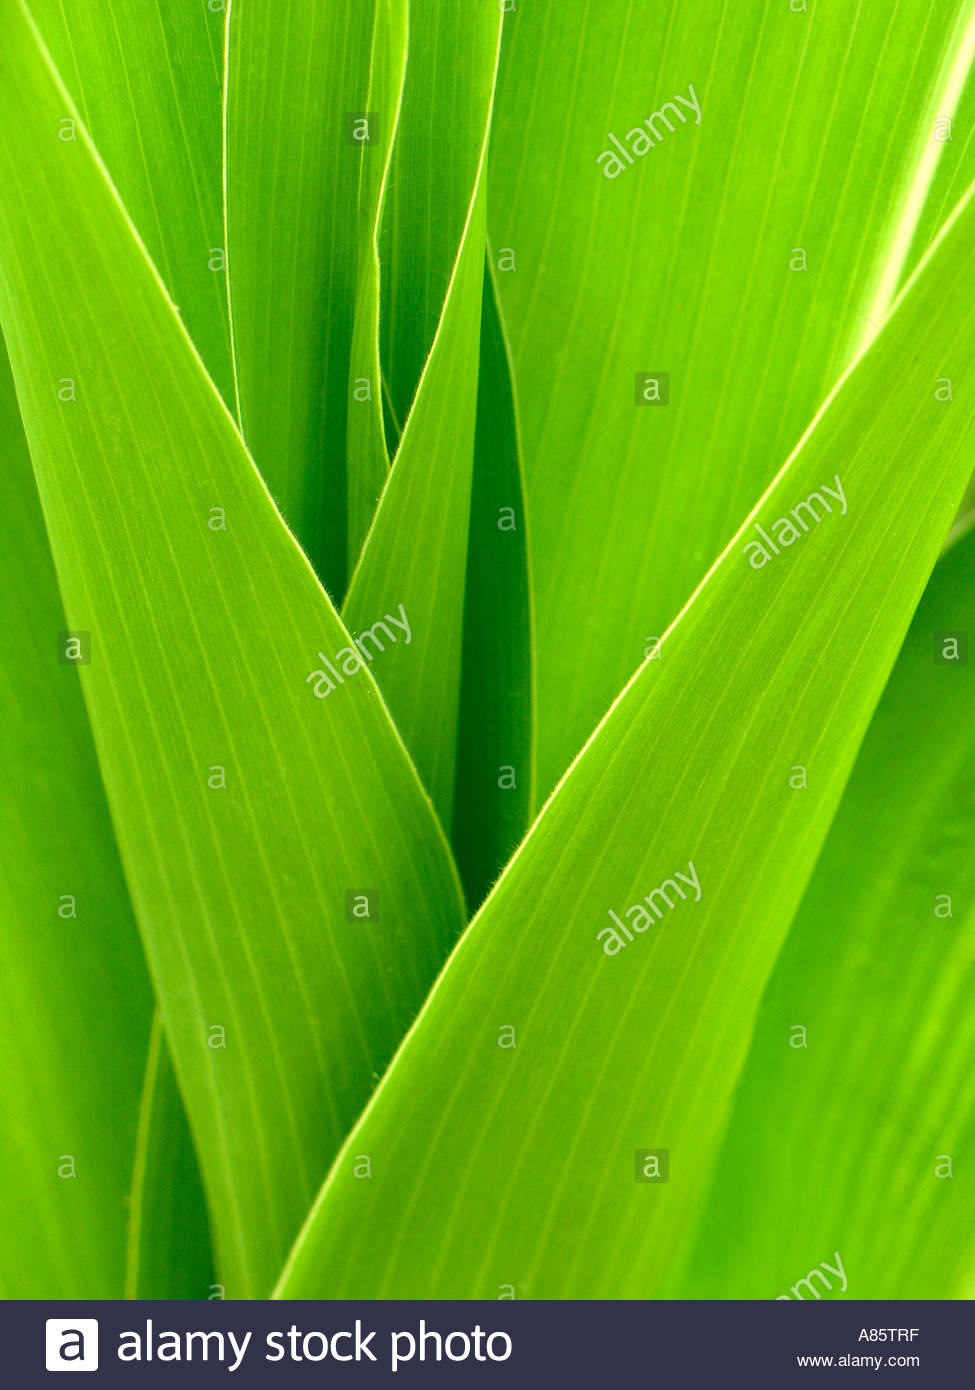

In [ ]:
healthy = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy[0]))

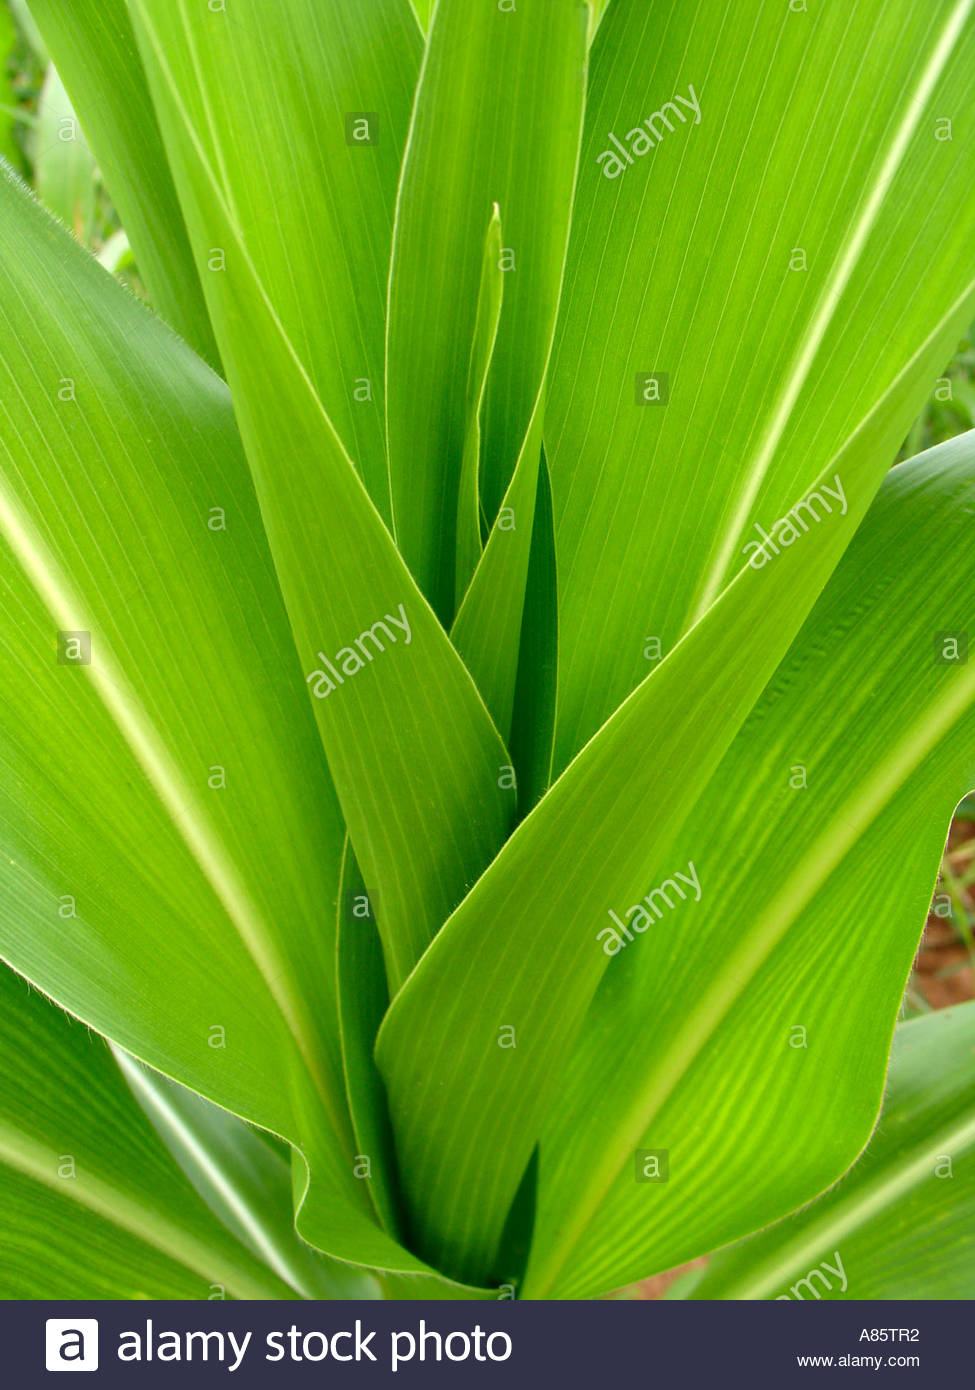

In [ ]:
PIL.Image.open(str(healthy[1]))

And some Corn leaves with Gray Leaf Spot, the most prevalent corn leaf disease:

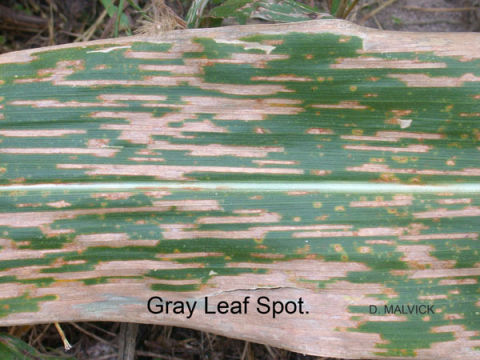

In [ ]:
grayLeaf = list(data_dir.glob('grayLeaf/*'))
PIL.Image.open(str(grayLeaf[0]))

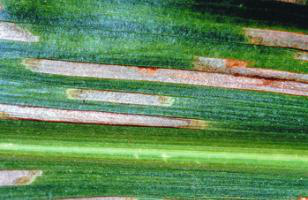

In [ ]:
PIL.Image.open(str(grayLeaf[1]))

## Create a dataset

Defining loader parameters:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Validation split: 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 106 files belonging to 2 classes.
Using 85 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 106 files belonging to 2 classes.
Using 21 files for validation.


## Visualize the data

Here are the first 9 images from the training dataset.

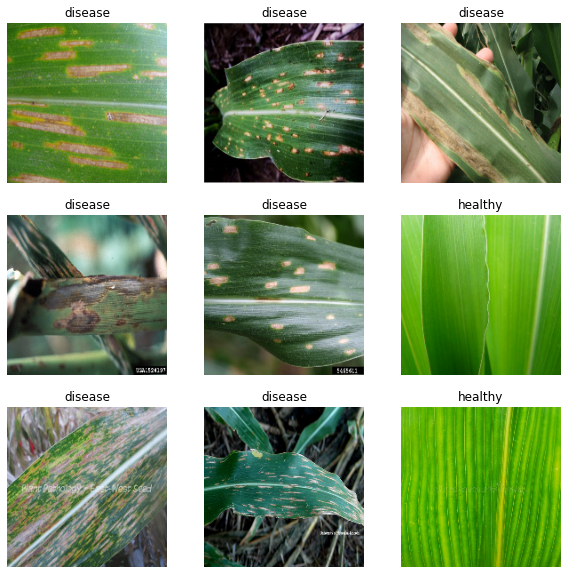

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configuring the dataset for performance
`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. 

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Applying it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of of this project is a proof-of-concept.

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

We chose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. The `metrics` argument shows training and validation accuracy for each epoch.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 30s 1s/step - loss: 1.1415 - accuracy: 0.6588 - val_loss: 1.5302 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 70ms/step - loss: 0.4618 - accuracy: 0.8471 - val_loss: 0.5690 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 0s 59ms/step - loss: 0.4509 - accuracy: 0.8941 - val_loss: 0.5552 - val_accuracy: 0.6667
Epoch 4/10
3/3 [==============================] - 0s 56ms/step - loss: 0.3404 - accuracy: 0.8471 - val_loss: 0.6738 - val_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 0s 55ms/step - loss: 0.2817 - accuracy: 0.8588 - val_loss: 0.3837 - val_accuracy: 0.7143
Epoch 6/10
3/3 [==============================] - 0s 50ms/step - loss: 0.2225 - accuracy: 0.9176 - val_loss: 0.2874 - val_accuracy: 0.9048
Epoch 7/10
3/3 [==============================] - 0s 53ms/step - loss: 0.2164 - accuracy: 0.9294 - val_loss: 0.3021 - val_accuracy: 0.8571
Epoch 8/10
3/3 [============

## Visualize training results

Plots of loss and accuracy on the training and validation sets.

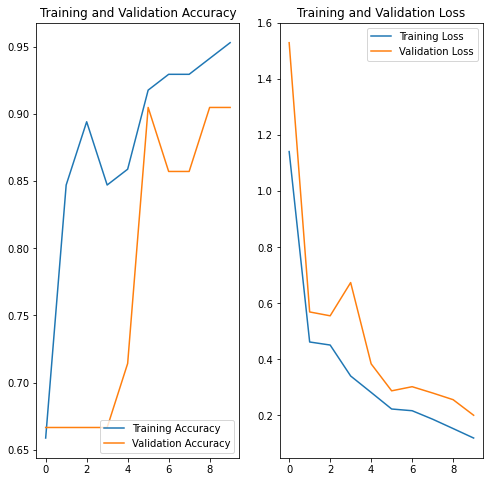

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

Implementing data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualize what a few augmented examples look like by applying data augmentation to the same image several times:

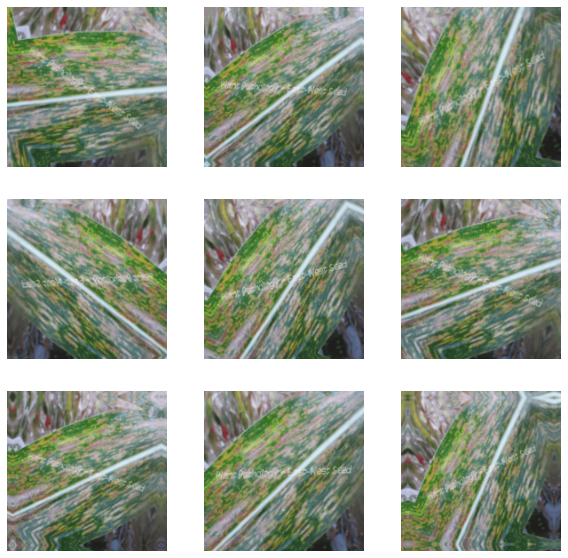

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

A form of *regularization*.

Randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 1s 147ms/step - loss: 1.7397 - accuracy: 0.8471 - val_loss: 1.5296 - val_accuracy: 0.6667
Epoch 2/15
3/3 [==============================] - 0s 62ms/step - loss: 0.5213 - accuracy: 0.8471 - val_loss: 0.6486 - val_accuracy: 0.6667
Epoch 3/15
3/3 [==============================] - 0s 57ms/step - loss: 0.5965 - accuracy: 0.8471 - val_loss: 0.6164 - val_accuracy: 0.6667
Epoch 4/15
3/3 [==============================] - 0s 56ms/step - loss: 0.4496 - accuracy: 0.8471 - val_loss: 0.7163 - val_accuracy: 0.6667
Epoch 5/15
3/3 [==============================] - 0s 57ms/step - loss: 0.3830 - accuracy: 0.8471 - val_loss: 0.7446 - val_accuracy: 0.6667
Epoch 6/15
3/3 [==============================] - 0s 56ms/step - loss: 0.3317 - accuracy: 0.8471 - val_loss: 0.4449 - val_accuracy: 0.6667
Epoch 7/15
3/3 [==============================] - 0s 56ms/step - loss: 0.2832 - accuracy: 0.8941 - val_loss: 0.5117 - val_accuracy: 0.6667
Epoch 8/15
3/3 [==========

## Visualize training results

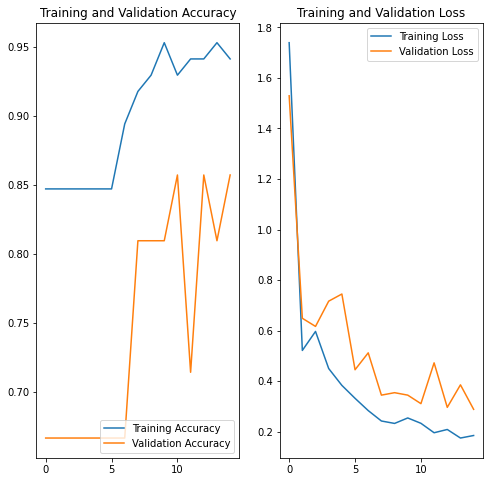

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, we use our model to classify an image that wasn't included in the training or validation sets.

In [ ]:
img_height = 180
img_width = 180

sunflower_url = "https://www.pannar.com/assets/disease_fact_sheets/leaf_Page_1_Image_0007.jpg"

#sunflower_path = tf.keras.utils.get_file('disease', origin=sunflower_url)

sunflower_path = pathlib.Path("gdrive/MyDrive/leaf_Page_1_Image_0007.jpg") #the diseased corn leaf
#sunflower_path = pathlib.Path("gdrive/MyDrive/green-corn-leaf-close-up-260nw-1689597223.jpg") #the healthy corn leaf

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#model = tf.keras.models.load_model('twoClass.h5')

predictions = model.predict(img_array)
print(predictions[0])
score = tf.nn.softmax(predictions[0])

print(score)

class_names = ["disease", "healthy"]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[ 2.308065  -2.0889113]
tf.Tensor([0.9878352  0.01216471], shape=(2,), dtype=float32)
[[ 2.308065  -2.0889113]]
This image most likely belongs to disease with a 98.78 percent confidence.


#Saving Models

In [ ]:
tf.keras.models.save_model(model,'twoClass.h5')